In [1]:
import sys
sys.path.append("..")

# December 1
It's nov 26 but I wanted to make this notebook now because the break might get my brani scattered. The meeting with mark was productive. We spoke about my complex demodulation work and digesting Janet's manuscript. An interesting finding within the manuscript was that the setup at mokulei'a was half of that as ipan, guam. Mark gave me a few tasks to keep me busy this next upcoming week. 
1) Azouri et al paper. Should talk about the Bosz model which is the precursor to Barracuda, the numerical model thats going to be used in this ONR project
2) Empirical work
    - Find Hs @ reef face and back refract [ Both holden and julia should have code for this]
    - $H_0$ vs setup
    - $(H_0L_0)^{1/2}$
3) $\bar{\eta} = cH_0$... what is c? linear regression can help with finding the coefficient but see if therre is a physical parameter
4) test 3) in Bosz... 2D vs 1D testing
5) Look at Athina's paper for parsing out bound IG waves in the IG band
6) Bispectral analysis can help distinguish beterrn bound and free IG waves but research needs to be done

In [2]:
import pandas as pd
from src.spectra import sensor_spectra
from src.bulk_parameters import Hs_band

# load data #
df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')

# 30 minute spectral averages#
nperseg= 3600 // 2 # 30 min at 1hz intervals

S1 = sensor_spectra(df1, nperseg=nperseg)
S6 = sensor_spectra(df6, nperseg=nperseg)

# compute Hs with freq cutoff @ 0.33 Hz
IG = (0.004, 0.04); SS = (0.05, 0.33); TOT = (0.004, 0.33)

Hs6 = Hs_band(S6, *SS)
Hs1 = Hs_band(S1, *SS)

#### Back-Refract to DW from sensor 6
assume a shore-normal waves by assuming that snesor 6 is shallow enough that effects of snells law are dominant. 

$H_0 = H_{s,6}\sqrt{\frac{C_{g,6}}{C_{g,0}}}$

                                    Hs6         Tp        H0         h6
time                                                                   
2007-12-14 12:15:01.003921408  1.786121  14.634210  1.645071  12.033676
2007-12-14 12:30:01.007838208  1.726074  13.846214  1.626725  12.169150
2007-12-14 12:45:01.011755007  1.752083  14.173290  1.635449  12.110083
2007-12-14 13:00:01.015671808  1.579092  13.333391  1.512499  12.336953
2007-12-14 13:15:01.019588608  1.463238  13.740518  1.383515  12.197973


Text(0, 0.5, 'Height (m)')

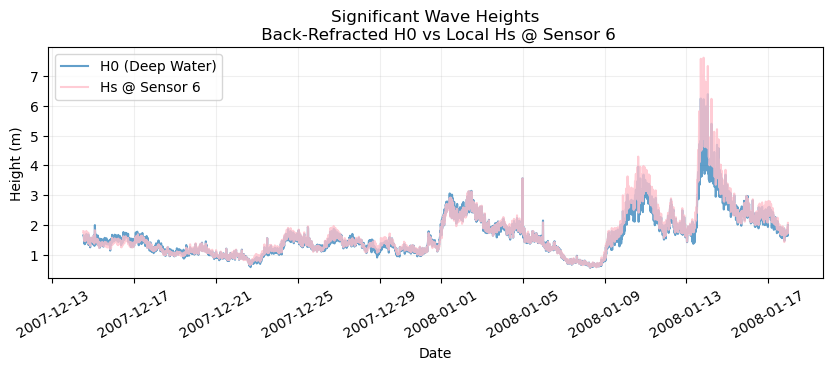

In [3]:
from src.bulk_parameters import compute_H0
import matplotlib.pyplot as plt

df_waves = compute_H0(S6, fmin=0.04, fmax=0.33)
print(df_waves.head())
H0 = df_waves['H0']
Hs6 = df_waves['Hs6']

plt.subplots(figsize=(10,3))
plt.plot(H0.index, H0, label = 'H0 (Deep Water)', alpha = 0.7)
plt.plot(Hs6.index, Hs6, label = 'Hs @ Sensor 6', alpha = 0.8, color = 'pink')
plt.legend(), plt.grid(True, alpha = 0.2)
plt.title('Significant Wave Heights\n Back-Refracted H0 vs Local Hs @ Sensor 6')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('Height (m)')

### Compute Setup

Created script that uses Becker et al (2014) method but its giving me issues. Using cross shore water level gradient for now. 

##### Becket et al method (in prog)

In [17]:
from src.setup import Becker_setup

df_setup = Becker_setup(df_waves, S1, S6)
# cross shore water level gradient method
h6_n = df_setup['h6'] - df_setup['h6'].mean()
h1_n = df_setup['h1'] - df_setup['h1'].mean()
df_setup['xshore_diff'] = h6_n - h1_n
# add tide to dataframe
tide = df6['h_tide'] - df6['h_tide'].mean()
tide_aligned = tide.reindex(df_setup.index, method='nearest')
df_setup['tide'] = tide_aligned

Calibration: Offset c=0.0207m, Drift b=-0.000226 m/hr


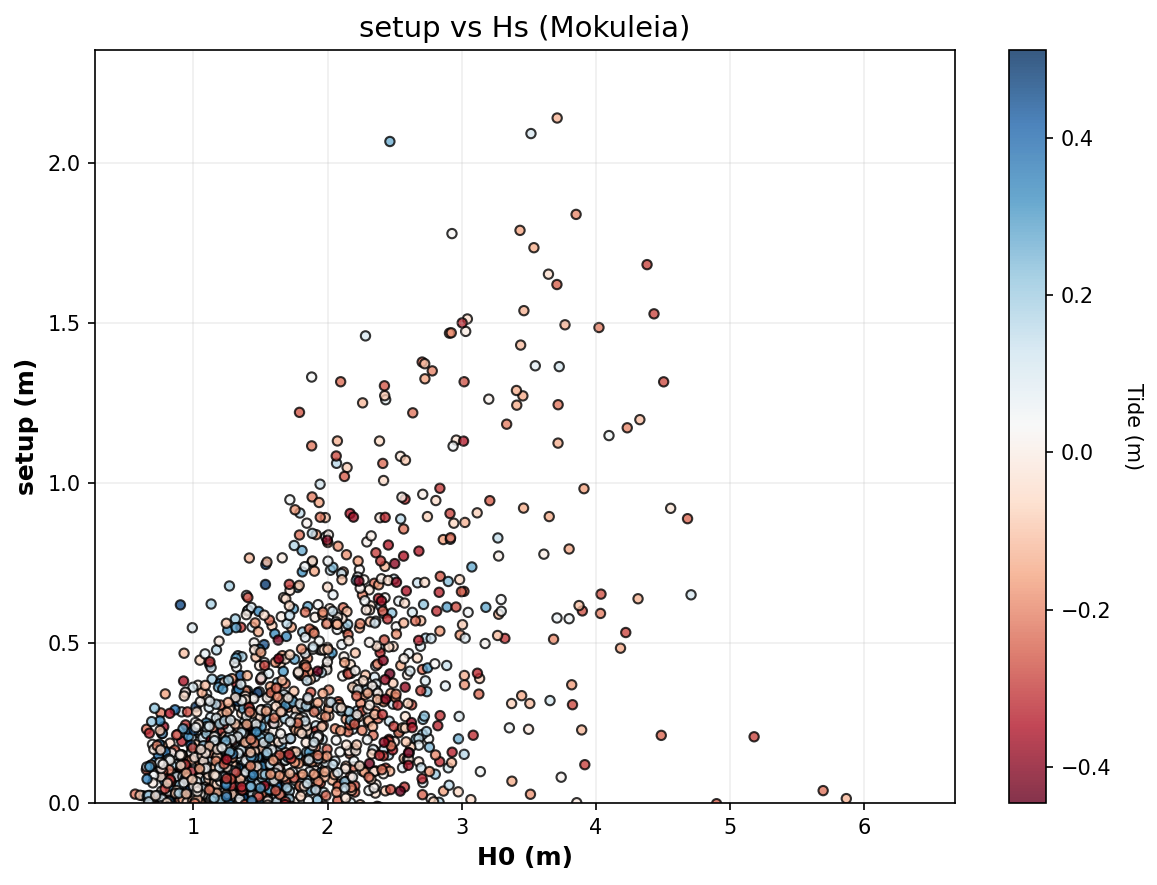

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load the Processed Data ---

# --- 2. Calculate Setup (Your Preferred Method) ---
# Logic: Setup = (h1 - h1_mean) - (h6 - h6_mean)
# Note: 'h1_detided' and 'h6_detided' in your results are already detided,
# but let's demean them to be safe and match your reference code exactly.

# Check if 'h1_detided' exists (it should from Becker_setup_custom)
if 'h1_detided' in df_setup.columns:
    p1 = df_setup['h1_detided'] - df_setup['h1_detided'].mean()
    p6 = df_setup['h6_detided'] - df_setup['h6_detided'].mean()
else:
    # Fallback to raw mean depths if detided columns missing
    p1 = df_setup['h1'] - df_setup['h1'].mean()
    p6 = df_setup['h6'] - df_setup['h6'].mean() # h6 is often called h_mean in spectra output

n_plot = p1 - p6

# --- 3. Calculate Tide for Colorbar ---
# Using the derived tide method you asked for: Tide = (h - h_detided) - Mean
# We need to reload df6 to get the raw 'h' and 'h_detided' for this
df6_raw = pd.read_csv('df6.csv', index_col=0, parse_dates=True)

# Calculate tide at 1Hz
raw_tide_signal = df6_raw['h'] - df6_raw['h_detided']
tide_centered = raw_tide_signal - raw_tide_signal.mean()

# Align to spectral timestamps (Same as your reference code's reindex step)
# df_setup.index are the spectral centers
tide_plot = tide_centered.reindex(df_setup.index, method='nearest', tolerance=pd.Timedelta('30min'))

# --- 4. Plotting ---
Hs_plot = df_setup['H0']

# Drop NaNs created by alignment gaps
valid = Hs_plot.notna() & n_plot.notna() & tide_plot.notna()

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# Scatter plot matching your "jet_r" style
sc = ax.scatter(Hs_plot[valid], n_plot[valid], 
                c=tide_plot[valid], 
                cmap="RdBu", 
                edgecolor="k", 
                s=20, alpha=0.8)

ax.set_xlabel("H0 (m)", fontsize=12, fontweight='bold')
ax.set_ylabel("setup (m)", fontsize=12, fontweight='bold')
ax.set_ylim(0,n_plot.max()*1.1)
ax.set_title("setup vs Hs (Mokuleia)", fontsize=14)
ax.grid(True, alpha=0.2)

# Colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Tide (m)", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

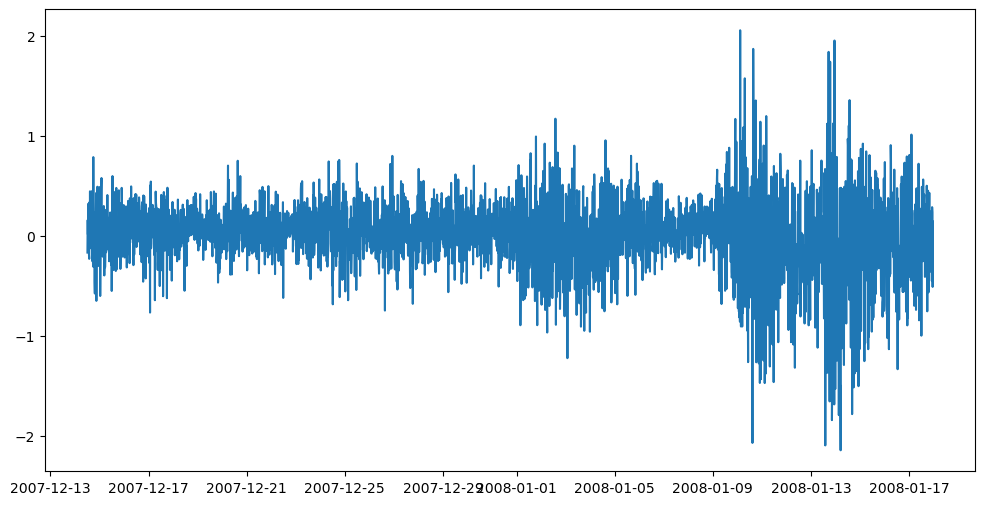

In [22]:
plt.figure(figsize=(12,6))
plt.plot(df_setup.index, df_setup['xshore_diff'])


##### Crossshore water level gradient 

In [3]:
from src.bulk_parameters import compute_H0

# 1. 30 minute spectral averages#
nperseg= 3600 // 2# 30 min at 1hz intervals
S1 = sensor_spectra(df1, nperseg=nperseg)
S6 = sensor_spectra(df6, nperseg=nperseg)

# 2. Wave field
df_waves = compute_H0(S6, fmin=0.05, fmax=0.33)
df_waves.head()
H0_ser = pd.Series(df_waves['H0'], index=pd.to_datetime(df_waves.index)).sort_index()

# ... [Step 1 and 2 (Spectral calculations) stay the same] ...

# 3. Calculate Setup from RAW data (More reliable than spectral averages)
# Use the original high-freq dataframes where you know timestamps are correct
# We resample to 1-min averages first to reduce noise, then subtract
raw_h1 = df1['h'].resample('1T').mean() # 1 min average
raw_h6 = df6['h'].resample('1T').mean()

# Align the raw tides
# This handles any start-time differences or missing data automatically
aligned_tides = pd.merge_asof(
    raw_h1.sort_index().to_frame('h1'),
    raw_h6.sort_index().to_frame('h6'),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=5)
).dropna()

# Calculate Setup (n) on this clean, aligned timeline
# n = (Shore - Mean_Shore) - (Offshore - Mean_Offshore)
p1 = aligned_tides['h1'] - aligned_tides['h1'].mean()
p6 = aligned_tides['h6'] - aligned_tides['h6'].mean()
n_raw = p1 - p6  # Correct direction: Shore - Offshore

# 4. Map the calculated 'n' to your Wave (H0) timestamps
# H0_ser is your target time base (from Step 2)
H0_df = H0_ser.to_frame(name='H0').sort_index()
n_df = n_raw.to_frame(name='n').sort_index()

# Merge Setup onto the Wave timestamps
final_df = pd.merge_asof(
    H0_df,
    n_df,
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30) # Grab the setup closest to the spectral burst
).dropna()

# --- 5. Align tide series to the existing spectral data ---

# A. Prepare the Tide Source
# We use df6 (Offshore) for the reference tide signal
tide_source = df6[['h_tide']].copy().sort_index()

# Calculate tidal anomaly (remove mean)
tide_source['tide_val'] = tide_source['h_tide'] - tide_source['h_tide'].mean()

# B. Merge tide onto the final aligned dataframe
# We merge into final_df to keep H0, n, and tide all on the exact same rows
final_df = pd.merge_asof(
    final_df,                    # The dataframe with H0 and n
    tide_source[['tide_val']],   # The tide data
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30) 
).dropna()

# --- 6. Final Variables for Plotting ---
H0_plot   = final_df['H0']
n_plot    = final_df['n']
tide_plot = final_df['tide_val']

print(f"Final data points: {len(final_df)}")

/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_40515/747659685.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  raw_h1 = df1['h'].resample('1T').mean() # 1 min average
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_40515/747659685.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  raw_h6 = df6['h'].resample('1T').mean()


Final data points: 3309


Text(0.5, 1.0, 'Cross-shore Water Level Gradient')

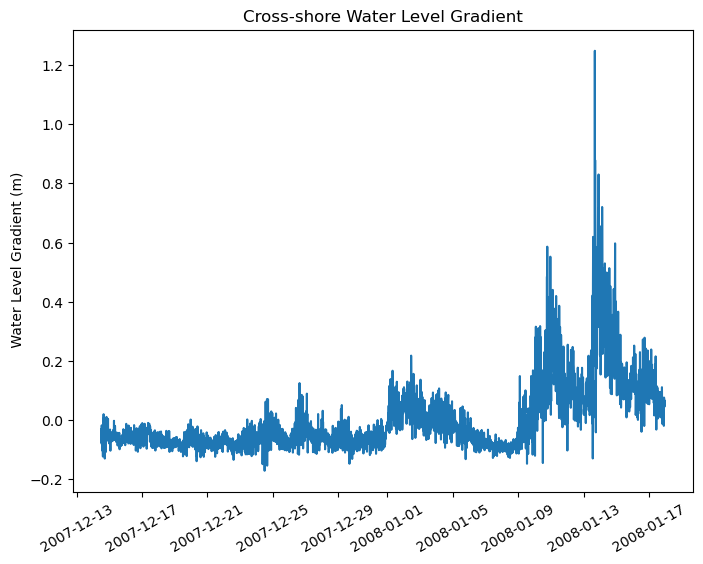

In [ ]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(8,6))
plt.plot(n_plot.index, n_plot)
plt.xticks(rotation=30)
plt.ylabel(' Water Level Gradient (m)')
plt.title('Cross-shore Water Level Gradient')


NameError: name 'valid' is not defined

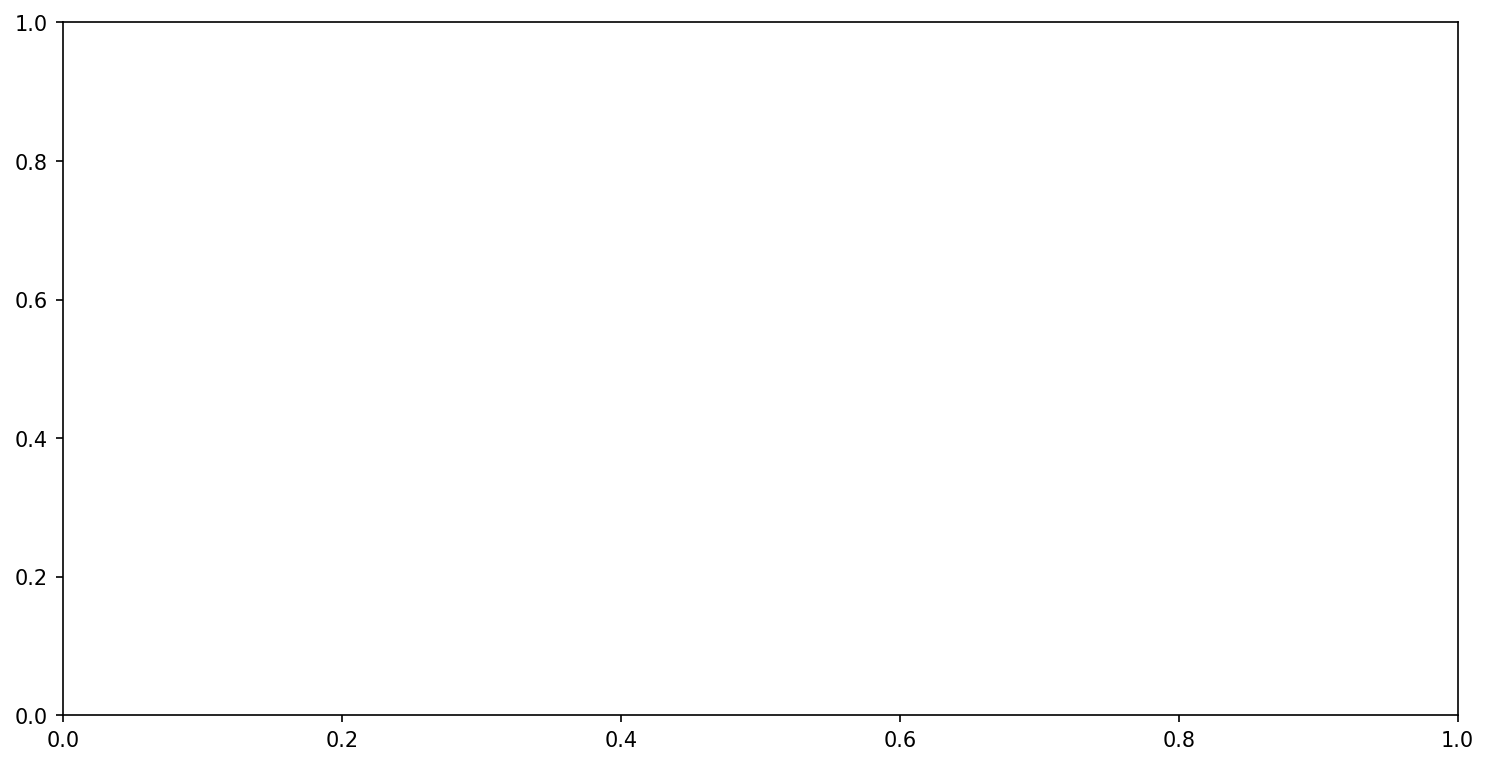

In [6]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

sc = ax.scatter(H0_plot[valid], n_plot[valid], 
                c=tide_plot[valid], 
                cmap="RdBu", 
                edgecolor="k", 
                s=40, alpha=0.8)

ax.set_xlabel("H0 (m)", fontsize=12, fontweight='bold')
ax.set_ylabel("setup (m)", fontsize=12, fontweight='bold')
#ax.set_ylim(0,n_plot.max()*1.1)
ax.set_title("setup vs H0 (Mokuleia)", fontsize=14)
ax.grid(True, alpha=0.2)

# Colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Tide (m)", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

KeyError: 'H0L0'

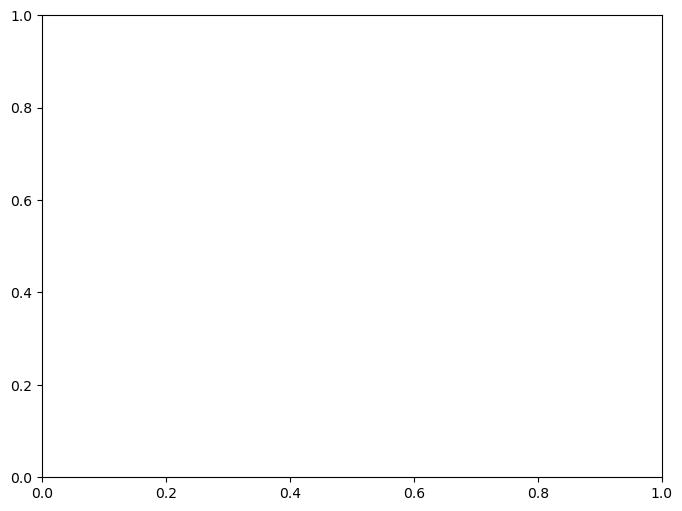

In [4]:
import numpy as np
import pandas as pd

# 1. Extract Peak Period (Tp) from the S6 xarray Dataset
# Find the frequency index with the maximum energy
fp_xarray = S6['Seta'].idxmax(dim='frequency') 
Tp_ser = (1.0 / fp_xarray).to_series().rename('Tp')

# 2. Align Tp with your existing final_df
# We use the same merge logic to ensure indices match perfectly
final_df = pd.merge_asof(
    final_df,
    Tp_ser.sort_index().to_frame(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30)
)

# 3. Compute L0 (Deep Water Wavelength)
# Formula: L0 = (g * T^2) / (2 * pi)
g = 9.81
final_df['L0'] = (g * final_df['Tp']**2) / (2 * np.pi)

# 4. Compute the product H0 * L0
final_df['scrt(H0L0)'] = np.sqrt(final_df['H0'] * final_df['L0'])

# --- Quick Plot to Check ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
sc = ax.scatter(final_df['H0L0'], final_df['n'], 
                c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=20, alpha=0.8)

ax.set_xlabel(r"$H_0 L_0$ ($m^2$)", fontsize=12, fontweight='bold')
ax.set_ylabel("Setup (m)", fontsize=12, fontweight='bold')
ax.set_title("Setup vs. Deep Water Wave Power Proxy ($H_0 L_0$)", fontsize=14)
ax.grid(True, alpha=0.2)
plt.colorbar(sc, label="Tide (m)")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# 1. Extract Peak Period (Tp) from the S6 xarray Dataset
# Find the frequency index with the maximum energy
fp_xarray = S6['Seta'].idxmax(dim='frequency') 
Tp_ser = (1.0 / fp_xarray).to_series().rename('Tp')

# 2. Align Tp with your existing final_df
# We use the same merge logic to ensure indices match perfectly
final_df = pd.merge_asof(
    final_df,
    Tp_ser.sort_index().to_frame(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30)
)

# 3. Compute L0 (Deep Water Wavelength)
# Formula: L0 = (g * T^2) / (2 * pi)
g = 9.81
final_df['L0'] = (g * final_df['Tp']**2) / (2 * np.pi)

# 4. Compute the product H0 * L0
final_df['H0L0'] = np.sqrt(final_df['H0'] * final_df['L0'])

# --- 5. Calculate Regressions ---

# Regression 1: Setup vs H0
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(final_df['H0'], final_df['n'])
r2_1 = r_value1**2
line1 = slope1 * final_df['H0'] + intercept1

# Regression 2: Setup vs H0L0
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(final_df['H0L0'], final_df['n'])
r2_2 = r_value2**2
line2 = slope2 * final_df['H0L0'] + intercept2

print(f"R^2 for H0:   {r2_1:.3f}")
print(f"R^2 for (H0L0)^1/2: {r2_2:.3f}")

# --- 6. Plotting Side-by-Side Comparison ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# Plot 1: Setup vs H0
sc1 = ax1.scatter(final_df['H0'], final_df['n'], 
                  c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=20, alpha=0.8)
ax1.plot(final_df['H0'], line1, 'k--', lw=2, label=f'Fit ($R^2={r2_1:.2f}$)')
ax1.set_xlabel("H0 (m)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Setup (m)", fontsize=12, fontweight='bold')
ax1.set_title(f"Setup vs H0\ny = {slope1:.3f}x + {intercept1:.3f}", fontsize=11)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.2)

# Plot 2: Setup vs H0L0
sc2 = ax2.scatter(final_df['H0L0'], final_df['n'], 
                  c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=20, alpha=0.8)
ax2.plot(final_df['H0L0'], line2, 'k--', lw=2, label=f'Fit ($R^2={r2_2:.2f}$)')
ax2.set_xlabel(r"$H_0 L_0$ ($m^2$)", fontsize=12, fontweight='bold')
ax2.set_ylabel("Setup (m)", fontsize=12, fontweight='bold')
ax2.set_title(f'Setup vs $\sqrt{H_0L_0}$\ny = {slope2:.3f}x + {intercept2:.3f}", fontsize=11)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.2)

# Shared Colorbar
cbar = fig.colorbar(sc2, ax=[ax1, ax2], fraction=0.02, pad=0.04)
cbar.set_label("Tide (m)", rotation=270, labelpad=15)

plt.show()

SyntaxError: unterminated f-string literal (detected at line 65) (943830846.py, line 65)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# 1. Extract Peak Period (Tp) from the S6 xarray Dataset
# Find the frequency index with the maximum energy
fp_xarray = S6['Seta'].idxmax(dim='frequency') 
#Tp_ser = (1.0 / fp_xarray).to_series().rename('Tp')

# 2. Align Tp with your existing final_df
# We use the same merge logic to ensure indices match perfectly
final_df = pd.merge_asof(
    final_df,
    Tp_ser.sort_index().to_frame(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30)
)

# 3. Compute L0 (Deep Water Wavelength)
# Formula: L0 = (g * T^2) / (2 * pi)
g = 9.81
final_df['L0'] = (g * final_df['Tp']**2) / (2 * np.pi)

# 4. Compute the proxy sqrt(H0 * L0)
# Note: H0 [m] * L0 [m] = [m^2], so sqrt(H0L0) has units of [m]
final_df['H0L0'] = final_df['H0'] * final_df['L0']
final_df['sqrt_H0L0'] = np.sqrt(final_df['H0L0'])

# --- 5. Calculate Regressions ---

# Regression 1: Setup vs H0
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(final_df['H0'], final_df['n'])
r2_1 = r_value1**2
line1 = slope1 * final_df['H0'] + intercept1

# Regression 2: Setup vs sqrt(H0L0)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(final_df['sqrt_H0L0'], final_df['n'])
r2_2 = r_value2**2
line2 = slope2 * final_df['sqrt_H0L0'] + intercept2

# Regression 2: Setup vs sqrt(H0L0)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(final_df['sqrt_H0L0'], final_df['n'])
r2_2 = r_value2**2
line2 = slope2 * final_df['sqrt_H0L0'] + intercept2

print(f"R^2 for H0:          {r2_1:.3f}")
print(f"R^2 for sqrt(H0L0):  {r2_2:.3f}")

# --- 6. Plotting Side-by-Side Comparison ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# Plot 1: Setup vs H0
sc1 = ax1.scatter(final_df['H0'], final_df['n'], 
                  c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=20, alpha=0.8)
ax1.plot(final_df['H0'], line1, 'k--', lw=2, label=f'Fit ($R^2={r2_1:.2f}$)')
ax1.set_xlabel("H0 (m)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Setup (m)", fontsize=12, fontweight='bold')
ax1.set_title(f"Setup vs H0\ny = {slope1:.3f}x + {intercept1:.3f}", fontsize=11)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.2)

# Plot 2: Setup vs sqrt(H0L0)
sc2 = ax2.scatter(final_df['sqrt_H0L0'], final_df['n'], 
                  c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=30, alpha=0.8)
ax2.plot(final_df['sqrt_H0L0'], line2, 'k--', lw=2, label=f'Fit ($R^2={r2_2:.2f}$)')
ax2.set_xlabel(r"$\sqrt{H_0 L_0}$ ($m$)", fontsize=12, fontweight='bold')
ax2.set_ylabel("Setup (m)", fontsize=12, fontweight='bold')
# Note: Double curly braces {{ }} are needed to escape the LaTeX {} inside an f-string
ax2.set_title(f"Setup vs $\sqrt{{H_0 L_0}}$\ny = {slope2:.3f}x + {intercept2:.3f}", fontsize=11)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.2)

# Shared Colorbar
cbar = fig.colorbar(sc2, ax=[ax1, ax2], fraction=0.02, pad=0.04)
cbar.set_label("Tide (m)", rotation=270, labelpad=15)

plt.show()

<>:73: SyntaxWarning: invalid escape sequence '\s'
<>:73: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_40515/3938135143.py:73: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_title(f"Setup vs $\sqrt{{H_0 L_0}}$\ny = {slope2:.3f}x + {intercept2:.3f}", fontsize=11)
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_40515/3938135143.py:73: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_title(f"Setup vs $\sqrt{{H_0 L_0}}$\ny = {slope2:.3f}x + {intercept2:.3f}", fontsize=11)


KeyError: 'Tp'

#### Irribarren number aside

Optimization Results:
Best Slope (tan beta): 0.025 (approx 1:40.2)
Best R^2: 0.640


/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_40515/1424939912.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


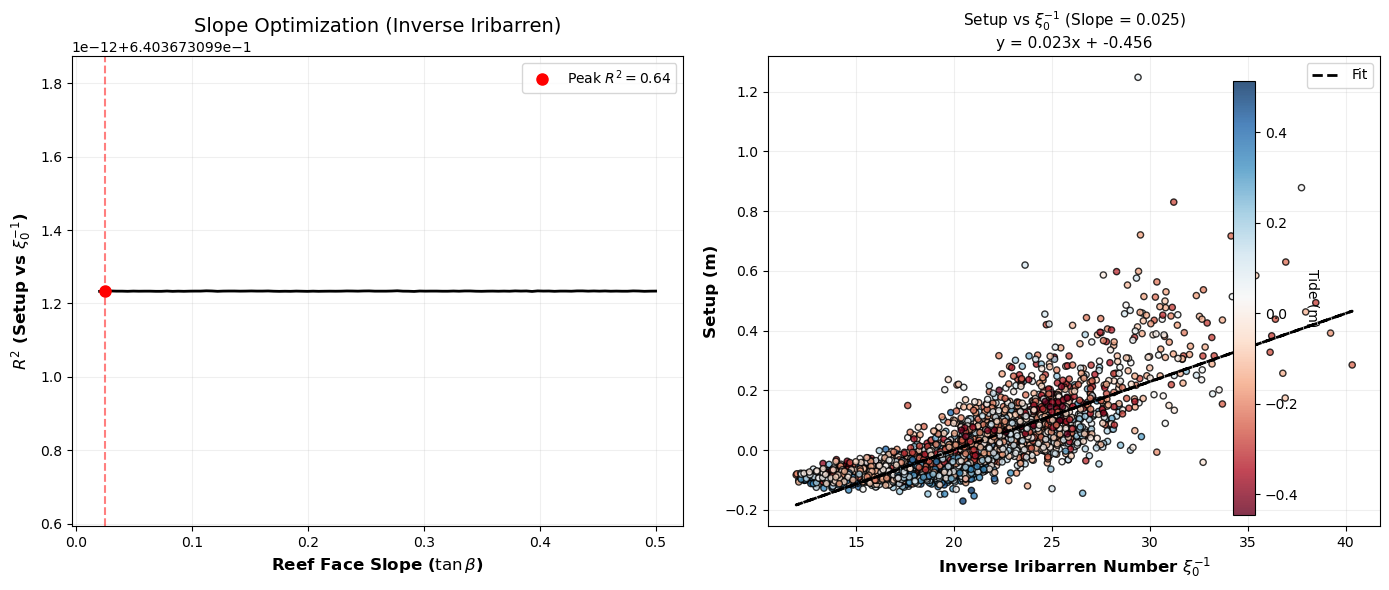

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. Robust Data Prep (Fixes "Run Twice" Error) ---

# Check if 'Tp' is already in the dataframe to avoid merge duplicates
if 'Tp' not in final_df.columns:
    # Extract Peak Period (Tp) from the S6 xarray Dataset
    if 'Seta' in S6:
        fp_xarray = S6['Seta'].idxmax(dim='frequency') 
        Tp_ser = (1.0 / fp_xarray).to_series().rename('Tp')
        
        # Merge Tp onto existing data
        final_df = pd.merge_asof(
            final_df,
            Tp_ser.sort_index().to_frame(),
            left_index=True,
            right_index=True,
            direction='nearest',
            tolerance=pd.Timedelta(minutes=30)
        )
    else:
        print("Warning: S6 dataset not available or missing 'Seta'. Skipping Tp extraction.")

# Ensure L0 is calculated
if 'L0' not in final_df.columns:
    g = 9.81
    final_df['L0'] = (g * final_df['Tp']**2) / (2 * np.pi)

# Ensure H0L0 proxies are calculated
if 'H0L0' not in final_df.columns:
    final_df['H0L0'] = final_df['H0'] * final_df['L0']
    final_df['sqrt_H0L0'] = np.sqrt(final_df['H0L0'])

# --- 2. Inverse Iribarren Number Loop (Slope Optimization) ---

# Define a range of slopes to test (tan beta). 
# 0.02 (1:50) to 0.5 (1:2) covers typical reef face slopes.
test_slopes = np.linspace(0.02, 0.5, 100) 
r2_results = []
slope_values = []

# Deep water steepness (s0 = H0 / L0)
s0 = final_df['H0'] / final_df['L0']

# Loop through slopes to find best fit
for m in test_slopes:
    # Calculate Inverse Iribarren number: xi_inv = sqrt(H0/L0) / tan(beta)
    xi_inv = np.sqrt(s0) / m
    
    # Perform linear regression: Setup vs Inverse Iribarren
    slope, intercept, r_value, p_value, std_err = stats.linregress(xi_inv, final_df['n'])
    
    r2_results.append(r_value**2)
    slope_values.append(m)

# Find the optimal slope
best_idx = np.argmax(r2_results)
best_slope = slope_values[best_idx]
best_r2 = r2_results[best_idx]

# Calculate Inverse Iribarren using the best slope for plotting
final_df['Inv_Iribarren'] = np.sqrt(s0) / best_slope

# Get regression stats for the best fit
slope_xi, intercept_xi, r_val_xi, p_val_xi, stderr_xi = stats.linregress(final_df['Inv_Iribarren'], final_df['n'])
line_xi = slope_xi * final_df['Inv_Iribarren'] + intercept_xi

print(f"Optimization Results:")
print(f"Best Slope (tan beta): {best_slope:.3f} (approx 1:{1/best_slope:.1f})")
print(f"Best R^2: {best_r2:.3f}")

# --- 3. Plotting ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# Plot 1: R^2 Optimization Curve
ax1.plot(slope_values, r2_results, 'k-', lw=2)
ax1.plot(best_slope, best_r2, 'ro', markersize=8, label=f'Peak $R^2={best_r2:.2f}$')
ax1.set_xlabel(r"Reef Face Slope ($\tan\beta$)", fontsize=12, fontweight='bold')
ax1.set_ylabel(r"$R^2$ (Setup vs $\xi_0^{-1}$)", fontsize=12, fontweight='bold')
ax1.set_title("Slope Optimization (Inverse Iribarren)", fontsize=14)
ax1.axvline(best_slope, color='r', linestyle='--', alpha=0.5)
ax1.legend()
ax1.grid(True, alpha=0.2)

# Plot 2: Setup vs Inverse Iribarren (at optimal slope)
sc = ax2.scatter(final_df['Inv_Iribarren'], final_df['n'], 
                 c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=20, alpha=0.8)
ax2.plot(final_df['Inv_Iribarren'], line_xi, 'k--', lw=2, label=f'Fit')

ax2.set_xlabel(r"Inverse Iribarren Number $\xi_0^{-1}$", fontsize=12, fontweight='bold')
ax2.set_ylabel("Setup (m)", fontsize=12, fontweight='bold')
# Using double backslash \\xi to avoid unicode error
ax2.set_title(f"Setup vs $\\xi_0^{{-1}}$ (Slope = {best_slope:.3f})\ny = {slope_xi:.3f}x + {intercept_xi:.3f}", fontsize=11)
ax2.grid(True, alpha=0.2)
ax2.legend()

# Shared Colorbar
cbar = fig.colorbar(sc, ax=[ax1, ax2], fraction=0.02, pad=0.04)
cbar.set_label("Tide (m)", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

Linear R^2:    0.640
Quadratic R^2: 0.678


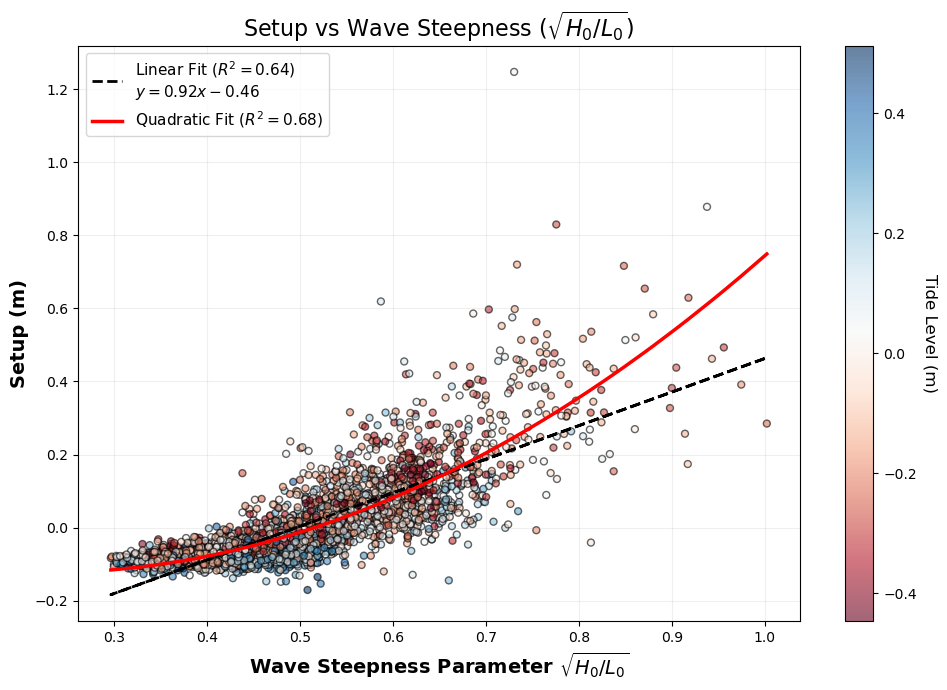

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. Robust Data Prep ---

# Check if 'Tp' is already in the dataframe to avoid merge duplicates
if 'Tp' not in final_df.columns:
    if 'Seta' in S6:
        fp_xarray = S6['Seta'].idxmax(dim='frequency') 
        Tp_ser = (1.0 / fp_xarray).to_series().rename('Tp')
        
        final_df = pd.merge_asof(
            final_df,
            Tp_ser.sort_index().to_frame(),
            left_index=True,
            right_index=True,
            direction='nearest',
            tolerance=pd.Timedelta(minutes=30)
        )
    else:
        print("Warning: S6 dataset not available. Skipping Tp extraction.")

if 'L0' not in final_df.columns:
    g = 9.81
    final_df['L0'] = (g * final_df['Tp']**2) / (2 * np.pi)

# --- 2. Calculate Wave Steepness Parameter ---
# We use sqrt(H0/L0) as the proxy for wave steepness
final_df['steepness_proxy'] = np.sqrt(final_df['H0'] / final_df['L0'])

# --- 3. Curve Fitting (Linear vs Quadratic) ---

x_data = final_df['steepness_proxy']
y_data = final_df['n']

# A. Linear Fit
slope_lin, intercept_lin, r_val_lin, _, _ = stats.linregress(x_data, y_data)
line_lin = slope_lin * x_data + intercept_lin
r2_lin = r_val_lin**2

# B. Quadratic Fit
# Fit polynomial: y = ax^2 + bx + c
coeffs = np.polyfit(x_data, y_data, 2)
poly_func = np.poly1d(coeffs)

# Calculate R^2 for quadratic
y_pred_quad = poly_func(x_data)
ss_res = np.sum((y_data - y_pred_quad)**2)
ss_tot = np.sum((y_data - np.mean(y_data))**2)
r2_quad = 1 - (ss_res / ss_tot)

# Sort x for plotting smooth curve
x_sort = np.sort(x_data)
y_quad_plot = poly_func(x_sort)

print(f"Linear R^2:    {r2_lin:.3f}")
print(f"Quadratic R^2: {r2_quad:.3f}")

# --- 4. Plotting ---

fig, ax = plt.subplots(figsize=(10, 7), dpi=100)

# Scatter Data
sc = ax.scatter(x_data, y_data, c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=25, alpha=0.6)

# Plot Linear Fit
ax.plot(x_data, line_lin, 'k--', lw=2, label=f'Linear Fit ($R^2={r2_lin:.2f}$)\n$y = {slope_lin:.2f}x {intercept_lin:+.2f}$')

# Plot Quadratic Fit
ax.plot(x_sort, y_quad_plot, 'r-', lw=2.5, label=f'Quadratic Fit ($R^2={r2_quad:.2f}$)')

# Labels and Styling
ax.set_xlabel(r"Wave Steepness Parameter $\sqrt{H_0 / L_0}$", fontsize=14, fontweight='bold')
ax.set_ylabel("Setup (m)", fontsize=14, fontweight='bold')
ax.set_title(r"Setup vs Wave Steepness ($\sqrt{H_0/L_0}$)", fontsize=16)
ax.legend(fontsize=11, loc='upper left', frameon=True)
ax.grid(True, alpha=0.2)

# Colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Tide Level (m)", rotation=270, labelpad=15, fontsize=12)

plt.tight_layout()
plt.show()

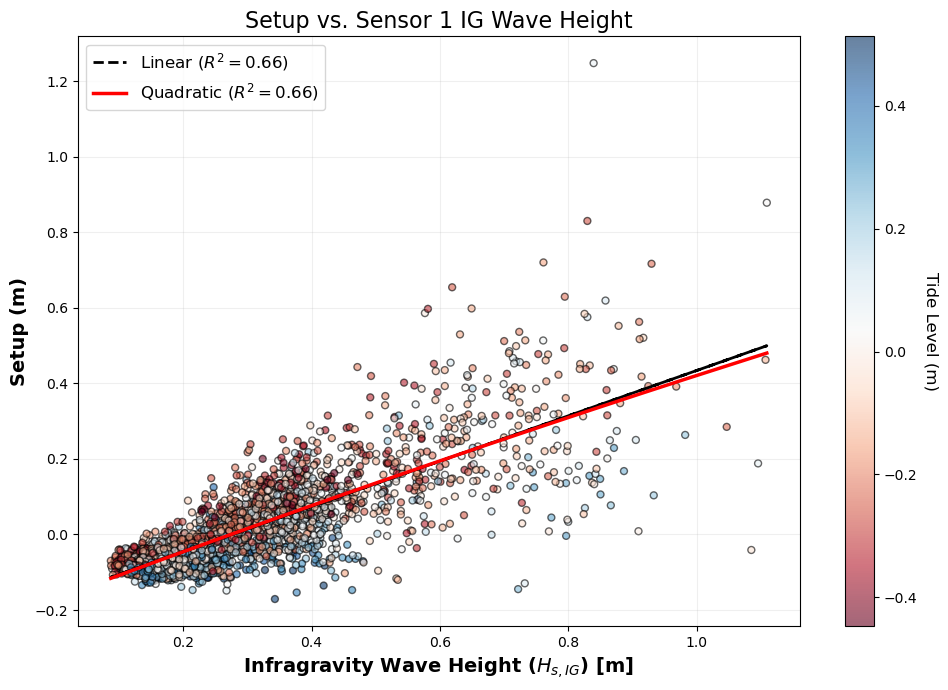

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr

# --- 0. Helper Function: Hs_band ---
def Hs_band(ds, fmin, fmax):
    """
    Computes Significant Wave Height (Hm0) over a specific frequency band.
    Assumes ds contains 'Seta' (spectral density m^2/Hz) and 'frequency' coord.
    """
    # Select the frequency band
    # subset using slice (handling potential float precision issues)
    subset = ds['Seta'].sel(frequency=slice(fmin, fmax))
    
    # Integrate Simpson's rule or Trapezoidal via xarray
    m0 = subset.integrate(coord='frequency')
    
    # Hm0 = 4 * sqrt(m0)
    Hs = 4 * np.sqrt(m0)
    
    # Convert to pandas Series for easy merging
    return Hs.to_series().sort_index()

# --- 1. Calculate Spectral Parameters ---

# Define Band
IG_band = (0.004, 0.04)

# Compute Onshore Infragravity (x-axis) -> Hs_IG_S1
# Note: Using S1 (Shore Sensor)
if 'S1' in locals():
    Hs1_IG = Hs_band(S1, *IG_band).rename('Hs1_IG')
else:
    print("Warning: S1 dataset not found. Cannot compute IG height.")
    Hs1_IG = None

# --- 2. Align Data with Final Dataframe ---

if Hs1_IG is not None:
    # Merge Shore IG into the main dataframe
    # We map S1 times to the existing timeline used in final_df
    final_df = pd.merge_asof(
        final_df.sort_index(),
        Hs1_IG.to_frame(),
        left_index=True,
        right_index=True,
        direction='nearest',
        tolerance=pd.Timedelta(minutes=30)
    )

# Drop any rows that failed to find a match (e.g. gaps in S1 data)
final_df = final_df.dropna(subset=['Hs1_IG'])

# --- 3. Curve Fitting ---

x_data = final_df['Hs1_IG']
y_data = final_df['n']

# A. Linear Fit
slope_lin, intercept_lin, r_val_lin, _, _ = stats.linregress(x_data, y_data)
line_lin = slope_lin * x_data + intercept_lin
r2_lin = r_val_lin**2

# B. Quadratic Fit
coeffs = np.polyfit(x_data, y_data, 2)
poly_func = np.poly1d(coeffs)

# Calculate R^2 for quadratic
y_pred_quad = poly_func(x_data)
ss_res = np.sum((y_data - y_pred_quad)**2)
ss_tot = np.sum((y_data - np.mean(y_data))**2)
r2_quad = 1 - (ss_res / ss_tot)

x_sort = np.sort(x_data)
y_quad_plot = poly_func(x_sort)

# --- 4. Plotting ---

fig, ax = plt.subplots(figsize=(10, 7), dpi=100)

# Scatter Data
sc = ax.scatter(x_data, y_data, c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=25, alpha=0.6)

# Plot Fits
ax.plot(x_data, line_lin, 'k--', lw=2, label=f'Linear ($R^2={r2_lin:.2f}$)')
ax.plot(x_sort, y_quad_plot, 'r-', lw=2.5, label=f'Quadratic ($R^2={r2_quad:.2f}$)')

# Labels
ax.set_xlabel(r"Infragravity Wave Height ($H_{s,IG}$) [m]", fontsize=14, fontweight='bold')
ax.set_ylabel("Setup (m)", fontsize=14, fontweight='bold')
ax.set_title("Setup vs. Sensor 1 IG Wave Height", fontsize=16)

ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.2)

# Colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Tide Level (m)", rotation=270, labelpad=15, fontsize=12)

plt.tight_layout()
plt.show()

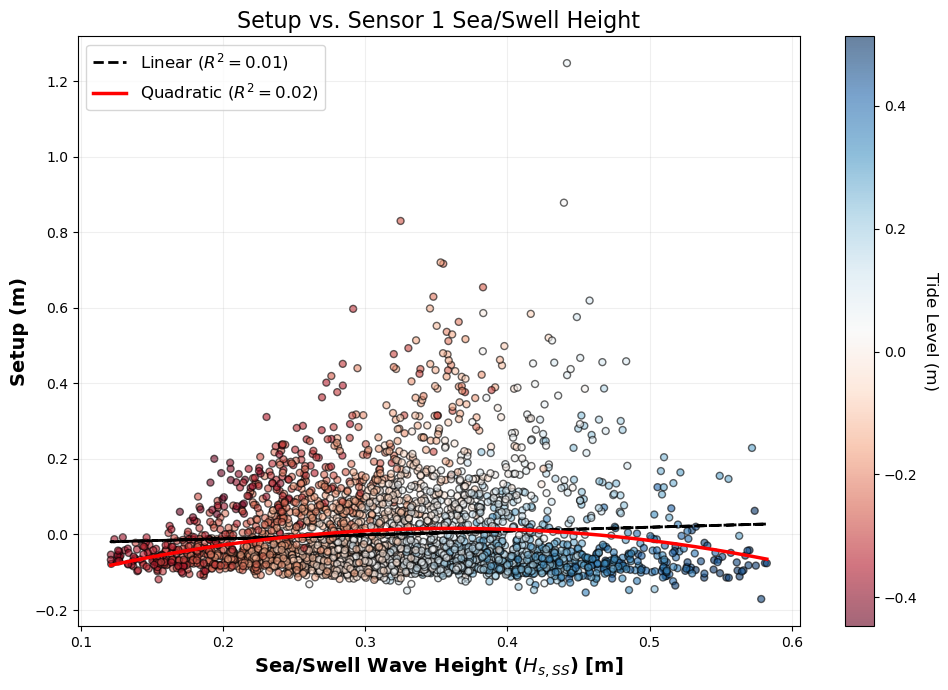

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr

# --- 0. Helper Function: Hs_band ---
def Hs_band(ds, fmin, fmax):
    """
    Computes Significant Wave Height (Hm0) over a specific frequency band.
    Assumes ds contains 'Seta' (spectral density m^2/Hz) and 'frequency' coord.
    """
    # Select the frequency band
    subset = ds['Seta'].sel(frequency=slice(fmin, fmax))
    
    # Integrate Simpson's rule or Trapezoidal via xarray
    m0 = subset.integrate(coord='frequency')
    
    # Hm0 = 4 * sqrt(m0)
    Hs = 4 * np.sqrt(m0)
    
    # Convert to pandas Series for easy merging
    return Hs.to_series().sort_index()

# --- 1. Calculate Spectral Parameters ---

# Define Band (Sea/Swell)
SS_band = (0.05, 0.33)

# Compute Onshore Sea/Swell (x-axis) -> Hs1_SS
if 'S1' in locals():
    Hs1_SS = Hs_band(S1, *SS_band).rename('Hs1_SS')
else:
    print("ERROR: 'S1' dataset not found in memory.")
    print("Please ensure you have run the cell that defines 'S1' (Sensor 1 Spectra).")
    Hs1_SS = None

# --- 2. Align Data with Final Dataframe ---

# Only proceed if we successfully calculated Hs1_SS
if Hs1_SS is not None:
    # Check if we already have this column to avoid duplicate suffixes
    if 'Hs1_SS' in final_df.columns:
        final_df = final_df.drop(columns=['Hs1_SS'])

    # Merge Shore SS into the main dataframe
    final_df = pd.merge_asof(
        final_df.sort_index(),
        Hs1_SS.to_frame(),
        left_index=True,
        right_index=True,
        direction='nearest',
        tolerance=pd.Timedelta(minutes=30)
    )

    # Drop any rows that failed to find a match
    final_df = final_df.dropna(subset=['Hs1_SS'])

    # --- 3. Curve Fitting ---
    x_data = final_df['Hs1_SS']
    y_data = final_df['n']

    # A. Linear Fit
    slope_lin, intercept_lin, r_val_lin, _, _ = stats.linregress(x_data, y_data)
    line_lin = slope_lin * x_data + intercept_lin
    r2_lin = r_val_lin**2

    # B. Quadratic Fit
    coeffs = np.polyfit(x_data, y_data, 2)
    poly_func = np.poly1d(coeffs)

    # Calculate R^2 for quadratic
    y_pred_quad = poly_func(x_data)
    ss_res = np.sum((y_data - y_pred_quad)**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    r2_quad = 1 - (ss_res / ss_tot)

    x_sort = np.sort(x_data)
    y_quad_plot = poly_func(x_sort)

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(10, 7), dpi=100)

    # Scatter Data
    sc = ax.scatter(x_data, y_data, c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=25, alpha=0.6)

    # Plot Fits
    ax.plot(x_data, line_lin, 'k--', lw=2, label=f'Linear ($R^2={r2_lin:.2f}$)')
    ax.plot(x_sort, y_quad_plot, 'r-', lw=2.5, label=f'Quadratic ($R^2={r2_quad:.2f}$)')

    # Labels
    ax.set_xlabel(r"Sea/Swell Wave Height ($H_{s,SS}$) [m]", fontsize=14, fontweight='bold')
    ax.set_ylabel("Setup (m)", fontsize=14, fontweight='bold')
    ax.set_title("Setup vs. Sensor 1 Sea/Swell Height", fontsize=16)

    ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, alpha=0.2)

    # Colorbar
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("Tide Level (m)", rotation=270, labelpad=15, fontsize=12)

    plt.tight_layout()
    plt.show()

else:
    print("Skipping plotting because Hs1_SS could not be calculated.")

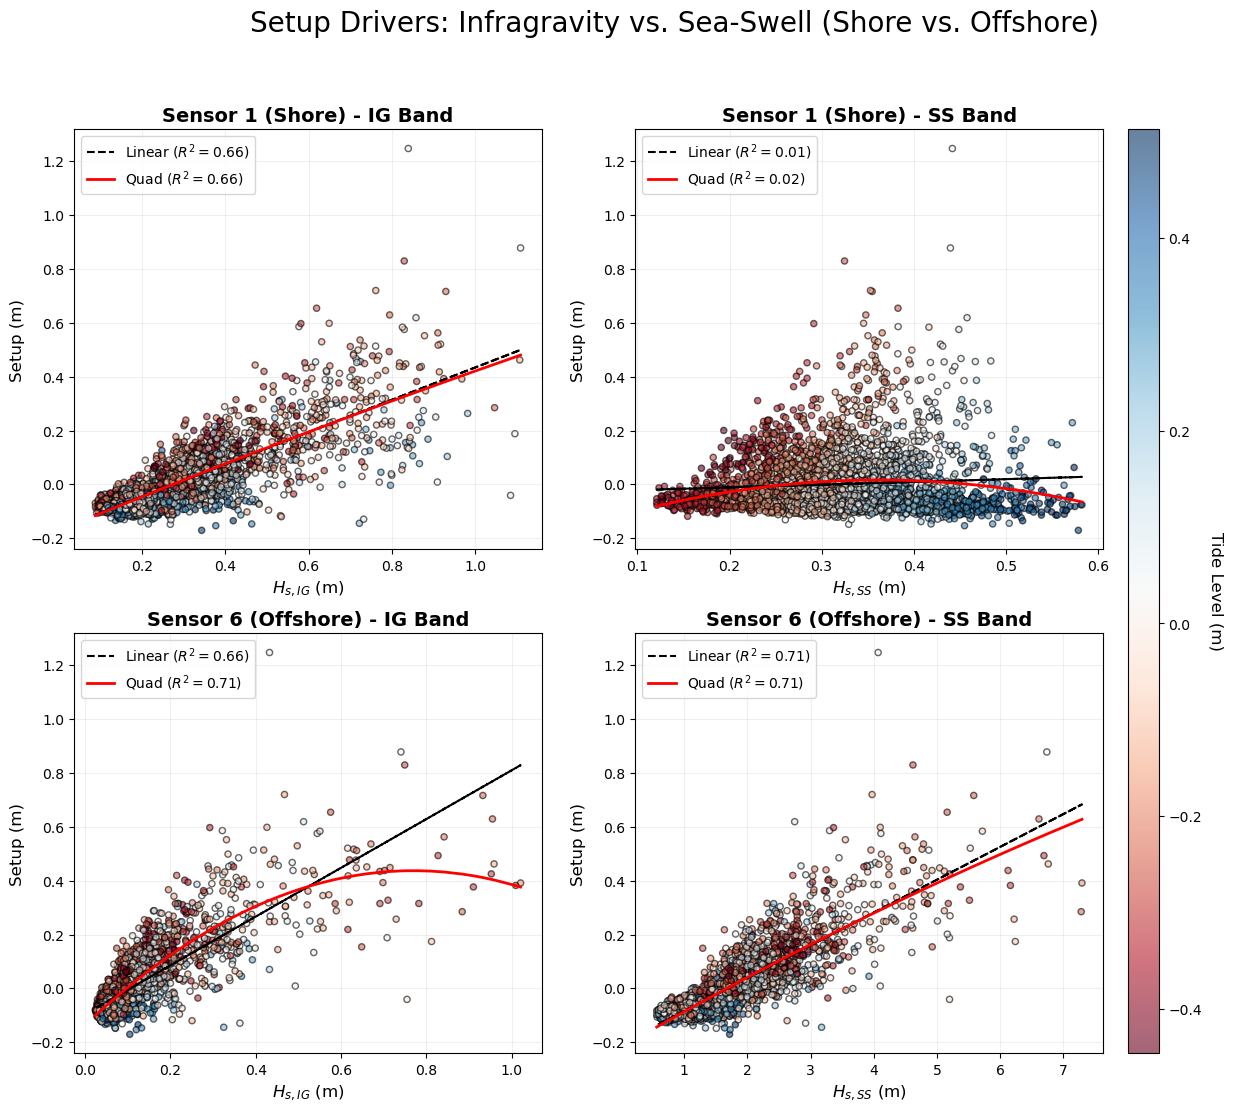

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr

# --- 0. Helper Function: Hs_band ---
def Hs_band(ds, fmin, fmax):
    """
    Computes Significant Wave Height (Hm0) over a specific frequency band.
    Assumes ds contains 'Seta' (spectral density m^2/Hz) and 'frequency' coord.
    """
    # Select the frequency band
    subset = ds['Seta'].sel(frequency=slice(fmin, fmax))
    
    # Integrate Simpson's rule or Trapezoidal via xarray
    m0 = subset.integrate(coord='frequency')
    
    # Hm0 = 4 * sqrt(m0)
    Hs = 4 * np.sqrt(m0)
    
    # Convert to pandas Series for easy merging
    return Hs.to_series().sort_index()

# --- 1. Calculate Spectral Parameters for All 4 Cases ---

# Define Bands
IG_band = (0.004, 0.04)
SS_band = (0.05, 0.33)

vars_to_calc = {}

# Check for S1 (Onshore)
if 'S1' in locals():
    vars_to_calc['Hs1_IG'] = Hs_band(S1, *IG_band)
    vars_to_calc['Hs1_SS'] = Hs_band(S1, *SS_band)
else:
    print("Warning: 'S1' dataset not found. Skipping S1 calculations.")

# Check for S6 (Offshore)
if 'S6' in locals():
    vars_to_calc['Hs6_IG'] = Hs_band(S6, *IG_band)
    vars_to_calc['Hs6_SS'] = Hs_band(S6, *SS_band)
else:
    print("Warning: 'S6' dataset not found. Skipping S6 calculations.")

# --- 2. Align Data with Final Dataframe ---

# Merge all calculated variables into final_df
for name, series in vars_to_calc.items():
    if name in final_df.columns:
        final_df = final_df.drop(columns=[name])
    
    final_df = pd.merge_asof(
        final_df.sort_index(),
        series.rename(name).to_frame(),
        left_index=True,
        right_index=True,
        direction='nearest',
        tolerance=pd.Timedelta(minutes=30)
    )

# Drop rows only if we are missing critical data for the plots
# (Adjust this if you want to plot partial data)
cols_needed = [k for k in vars_to_calc.keys()]
final_df = final_df.dropna(subset=cols_needed + ['n'])

# --- 3. Plotting Grid (2x2) ---

fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
axes = axes.flatten()

# Define the 4 plots configuration
plot_configs = [
    {'x': 'Hs1_IG', 'title': 'Sensor 1 (Shore) - IG Band', 'xlabel': r'$H_{s,IG}$ (m)'},
    {'x': 'Hs1_SS', 'title': 'Sensor 1 (Shore) - SS Band', 'xlabel': r'$H_{s,SS}$ (m)'},
    {'x': 'Hs6_IG', 'title': 'Sensor 6 (Offshore) - IG Band', 'xlabel': r'$H_{s,IG}$ (m)'},
    {'x': 'Hs6_SS', 'title': 'Sensor 6 (Offshore) - SS Band', 'xlabel': r'$H_{s,SS}$ (m)'},
]

for i, config in enumerate(plot_configs):
    ax = axes[i]
    x_col = config['x']
    
    if x_col not in final_df.columns:
        ax.text(0.5, 0.5, f"Data {x_col} Missing", ha='center')
        continue

    x_data = final_df[x_col]
    y_data = final_df['n']

    # --- Curve Fitting ---
    # A. Linear
    slope, intercept, r_val, _, _ = stats.linregress(x_data, y_data)
    line_lin = slope * x_data + intercept
    r2_lin = r_val**2
    
    # B. Quadratic
    coeffs = np.polyfit(x_data, y_data, 2)
    poly_func = np.poly1d(coeffs)
    y_pred_quad = poly_func(x_data)
    ss_res = np.sum((y_data - y_pred_quad)**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    r2_quad = 1 - (ss_res / ss_tot)
    x_sort = np.sort(x_data)
    y_quad_plot = poly_func(x_sort)

    # --- Plotting ---
    sc = ax.scatter(x_data, y_data, c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=20, alpha=0.6)
    
    ax.plot(x_data, line_lin, 'k--', lw=1.5, label=f'Linear ($R^2={r2_lin:.2f}$)')
    ax.plot(x_sort, y_quad_plot, 'r-', lw=2, label=f'Quad ($R^2={r2_quad:.2f}$)')
    
    ax.set_title(config['title'], fontsize=14, fontweight='bold')
    ax.set_xlabel(config['xlabel'], fontsize=12)
    ax.set_ylabel("Setup (m)", fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.2)

# Shared Colorbar
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), pad=0.02, aspect=30)
cbar.set_label("Tide Level (m)", rotation=270, labelpad=15, fontsize=12)

fig.suptitle("Setup Drivers: Infragravity vs. Sea-Swell (Shore vs. Offshore)", fontsize=20)
#plt.tight_layout() # often conflicts with shared colorbar, adjust manually if needed
plt.show()

Using existing 'H0' column in final_df.
Regression Results:
Equation: Setup = 0.1356 * H0 + -0.2214
R^2: 0.674


<>:62: SyntaxWarning: invalid escape sequence '\e'
<>:66: SyntaxWarning: invalid escape sequence '\e'
<>:62: SyntaxWarning: invalid escape sequence '\e'
<>:66: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_40515/3671222361.py:62: SyntaxWarning: invalid escape sequence '\e'
  label_text = f'Fit: $\eta = {slope:.3f} H_0 {intercept:+.3f}$\n($R^2={r2:.2f}$)'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_40515/3671222361.py:66: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel("Setup $\eta$ (m)", fontsize=14, fontweight='bold')


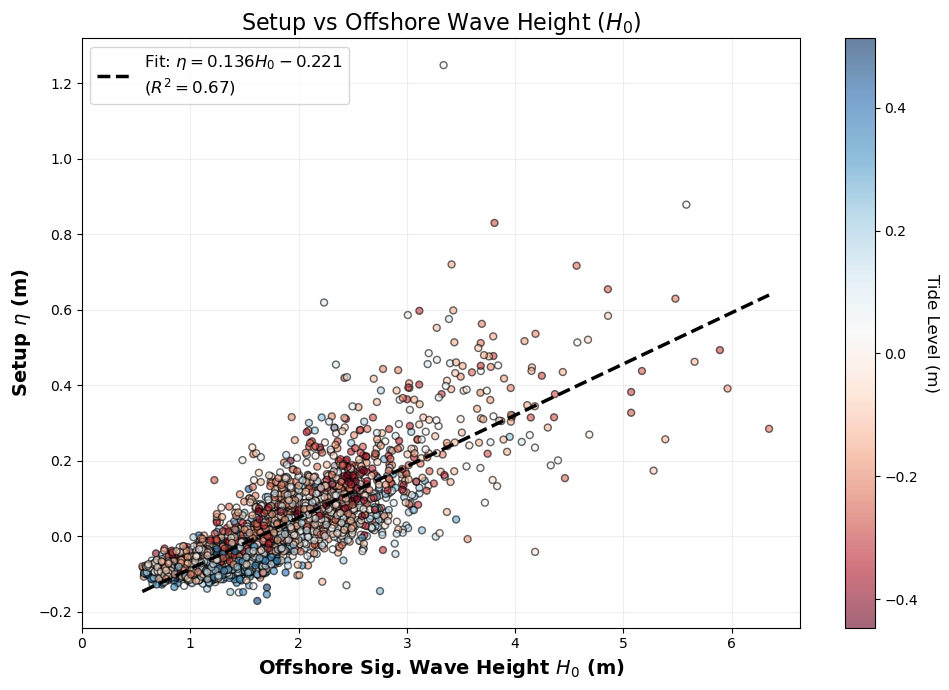

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. Ensure H0 (Back Refracted) is present ---

# We want to use the 'H0' computed earlier (via back-refraction/linear theory)
# rather than recalculating it from S6 raw spectra.

if 'H0' in final_df.columns:
    print("Using existing 'H0' column in final_df.")
    # Ensure it's numeric
    final_df['H0'] = pd.to_numeric(final_df['H0'], errors='coerce')

elif 'H0_ser' in locals():
    print("Merging 'H0_ser' (Back-refracted) into dataframe...")
    # Prepare H0 frame from the variable in memory
    h0_frame = H0_ser.sort_index().to_frame(name='H0')
    
    # Merge onto final_df
    final_df = pd.merge_asof(
        final_df.sort_index(),
        h0_frame,
        left_index=True,
        right_index=True,
        direction='nearest',
        tolerance=pd.Timedelta(minutes=30)
    )
else:
    print("CRITICAL ERROR: 'H0' column missing in final_df and 'H0_ser' variable not found.")
    print("Please ensure Step 2 (compute_H0) has been run.")

# Filter clean data
final_df = final_df.dropna(subset=['H0', 'n'])

# --- 2. Compute Standard Linear Regression (With Intercept) ---

x = final_df['H0'].values
y = final_df['n'].values

# Calculate slope, intercept, and r-value
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r2 = r_value**2

# Create the fitted line
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept

print(f"Regression Results:")
print(f"Equation: Setup = {slope:.4f} * H0 + {intercept:.4f}")
print(f"R^2: {r2:.3f}")

# --- 3. Plotting ---

fig, ax = plt.subplots(figsize=(10, 7), dpi=100)

# Scatter Data
sc = ax.scatter(x, y, c=final_df['tide_val'], cmap="RdBu", edgecolor="k", s=25, alpha=0.6)

# Plot the Fitted Line
label_text = f'Fit: $\eta = {slope:.3f} H_0 {intercept:+.3f}$\n($R^2={r2:.2f}$)'
ax.plot(x_line, y_line, 'k--', lw=2.5, label=label_text)

ax.set_xlabel(r"Offshore Sig. Wave Height $H_0$ (m)", fontsize=14, fontweight='bold')
ax.set_ylabel("Setup $\eta$ (m)", fontsize=14, fontweight='bold')
ax.set_title(r"Setup vs Offshore Wave Height ($H_0$)", fontsize=16)

ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.2)
ax.set_xlim(left=0)

# Colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Tide Level (m)", rotation=270, labelpad=15, fontsize=12)

plt.tight_layout()
plt.show()

In [21]:
5/16

0.3125